# Build Hotnet2 Network Container
In this notebook, I want to construct the network container for the Hotnet2 data. In order to do that, I have to do the following:
1. Construct a network from heat scores and edgelist (data in Hotnet2 github repo)
2. Get labels (positive and negative) from OMIM
3. Do train/test split and save the whole thing


In [33]:
import pandas as pd
import numpy as np
import h5py
import networkx as nx
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## 1. Construct Network

In [31]:
# read edgelist and names
net_file = '../data/cancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
name_file = '../data/cancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
edgelist = pd.read_csv(net_file, sep=' ', header=None,
                       names=['from', 'to', 'weight'])
index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])

# build network and relabel nodes to match with real names
G = nx.from_pandas_dataframe(edgelist, source='from', target='to', edge_attr=None)
print (G.number_of_edges(), G.number_of_nodes())
nx.relabel_nodes(G, index.to_dict()['name'], copy=False)

G.number_of_edges(), G.number_of_nodes()

91809 12129


(91809, 12129)

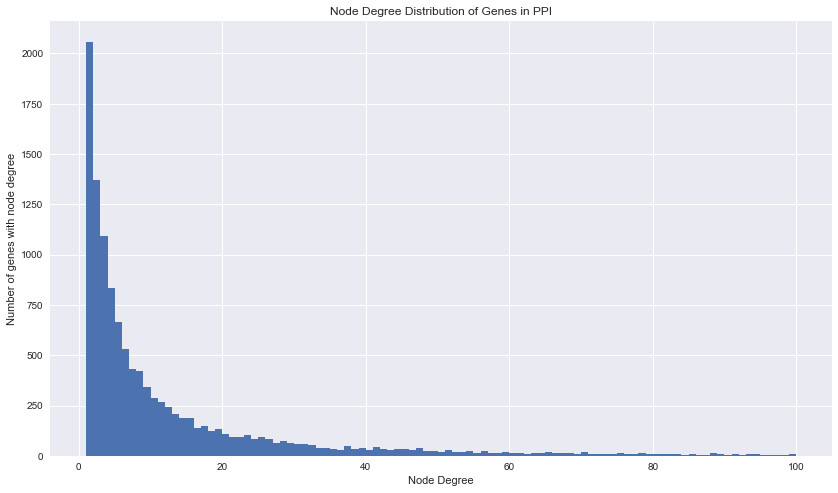

In [44]:
# plot node degree to check if distribution follows power law
node_degrees = np.array([i[1] for i in list(G.degree())])
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(1, 100, 100)
ax = plt.hist(node_degrees, bins)
plt.xlabel('Node Degree')
plt.ylabel('Number of genes with node degree')
plt.title('Node Degree Distribution of Genes in PPI')

In [71]:
# self interactions?
assert (np.diag(nx.to_numpy_array(G)).sum() == 0)

In [48]:
# get edgelist with names from the networkx graph
l = nx.to_edgelist(G)
f = [i[0] for i in l]
t = [i[1] for i in l]
edges_names = pd.DataFrame(np.array([f, t]).T, columns=['from_node', 'to_node'])

# get heat scores and see which ones are in our network
heat_file = '../data/cancer/hotnet2/heats/pan12.gene2mutsig.txt'
heat_scores = pd.read_csv(heat_file, header=None, sep=' ',
                          names=['gene_name', 'heat'], index_col=0)
nx.set_node_attributes(G, heat_scores.to_dict()['heat'], name='heat')

In [65]:
G.nodes['ABLIM1']['heat']

0.221192881382

In [66]:
heat_scores[~(heat_scores.index.isin(edges_names.from_node) | heat_scores.index.isin(edges_names.to_node))].shape

(2557, 1)

In [67]:
heat_scores[heat_scores.index.isin(edges_names.from_node) | heat_scores.index.isin(edges_names.to_node)].shape

(8658, 1)

## 2. Get Labels from OMIM